1) В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.) 

(**Реализую в модуле 8**)

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles,make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3 # !критерий останова 1 по колличеству листьев, будет!

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf: # используем наш критерий останова №1 по кол-ву листьев
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain and (len(np.unique(true_labels)) == 1 or len(np.unique(false_labels)) == 1): #крит. останова №2 если все обьекты относятся к 1му классу, то заканчиваем, лучше не будет.
                best_gain, best_t, best_index = current_gain, t, index
                break
                
            elif current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [9]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [13]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= -2.017035357279922
--> True:
  Прогноз: 0
--> False:
  Индекс 1 <= 0.05877427080072417
  --> True:
    Индекс 0 <= -1.6685911660293056
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -1.1845330075719176
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0 <= -0.9749918375411485
        --> True:
          Прогноз: 0
        --> False:
          Индекс 0 <= -0.931427286340031
          --> True:
            Прогноз: 0
          --> False:
            Индекс 0 <= -0.26751423090801474
            --> True:
              Индекс 0 <= -0.8411814419026544
              --> True:
                Прогноз: 0
              --> False:
                Прогноз: 0
            --> False:
              Индекс 1 <= -1.6706488723974264
              --> True:
                Прогноз: 1
              --> False:
                Индекс 0 <= -0.05059925053749681
                --> True:
                  Прогноз: 1
                --> False:
                  Прог

In [15]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [16]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.33333333333333

In [20]:
# Визуализируем дерево на графике

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

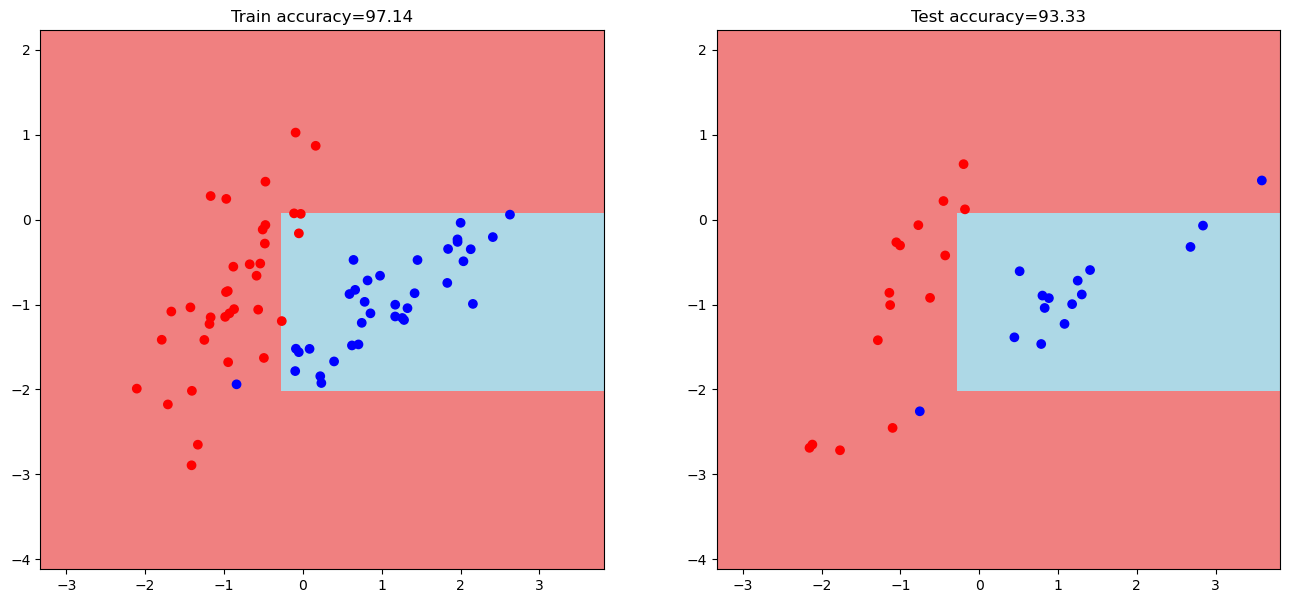

In [21]:
visualize(train_data, test_data)



2) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.



In [22]:
# сгенерируем данные
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

In [23]:
train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, 
                                                                                        targets, 
                                                                                        test_size=0.3,
                                                                                        random_state=5)

In [24]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [25]:
# И класс терминального узла (листа), с заменой на взятие среднего.

class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean() # берем среднее по выборке 

In [26]:
# Заменяем критерий Джини на дисперсию значений, дисперсию значений будем представлять через mse.
def mse(targets):
    return np.mean((targets - targets.mean())**2)

In [27]:
# Нахождение наилучшего разбиения

def find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_targets, false_targets = split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf: # используем наш критерий останова №1 по кол-ву листьев
                continue
            
            current_gain = gain(true_targets, false_targets, root_mse, mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [28]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)

    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)

    false_branch = build_tree(false_data, false_target)

    node = Node(index, t, true_branch, false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return node

In [29]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

Индекс 0 <= 0.03654264148725312
--> True:
  Индекс 0 <= -0.689565232048181
  --> True:
    Индекс 0 <= -1.167278449710173
    --> True:
      Прогноз: -115.73552947356616
    --> False:
      Индекс 1 <= -0.9806078852186219
      --> True:
        Прогноз: -72.63643141903327
      --> False:
        Прогноз: -54.320766990668275
  --> False:
    Индекс 1 <= 1.1415077374346698
    --> True:
      Индекс 1 <= -0.5983599334221348
      --> True:
        Индекс 0 <= -0.2151878024236405
        --> True:
          Прогноз: -32.48604383545746
        --> False:
          Прогноз: -27.361561244695594
      --> False:
        Индекс 0 <= -0.32986995777935924
        --> True:
          Индекс 1 <= 0.18760322583703548
          --> True:
            Прогноз: -23.092201261230116
          --> False:
            Прогноз: -18.610760952563393
        --> False:
          Индекс 0 <= -0.2021181776204691
          --> True:
            Прогноз: -4.4093069770772395
          --> False:
            Прог

In [31]:
train_answers = predict(train_data_regr, my_tree)
train_r2 = r2_score(train_target_regr, train_answers)
print(train_r2)

answers = predict(test_data_regr, my_tree)
test_r2 = r2_score(test_target_regr, answers)
print(test_r2)

0.9738081858683403
0.9098809576379733
